## <span style="color:darkblue; font-weight:bold"> A. Setups </span>

In [2]:
import os
print(os.getcwd())

/workspaces/car-price-prediction


In [3]:
#Import modules=================================================================================================================
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import re
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.tree import DecisionTreeRegressor 

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
#from sklearn.tree import plot_tree

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

import xgboost as xgb
from xgboost import XGBRegressor
from xgboost import plot_tree
from xgboost import plot_importance

#from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split

#from sklearn.model_selection import GridSearchCV
from skopt import BayesSearchCV

In [4]:
#Setup some visual properties=================================================================================================================
plt.style.use('seaborn-v0_8')
mpl.rcParams['font.family'] = "sans-serif"
%matplotlib inline

In [34]:
#Read files=====================================================================================================================
data = pd.read_csv("Data/cleaned_data.csv")
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   year           6000 non-null   int64  
 1   selling_price  6000 non-null   int64  
 2   km_driven      6000 non-null   int64  
 3   fuel           6000 non-null   object 
 4   seller_type    6000 non-null   object 
 5   transmission   6000 non-null   object 
 6   owner          6000 non-null   object 
 7   mileage        5828 non-null   float64
 8   engine         5841 non-null   float64
 9   max_power      5840 non-null   float64
 10  torque         5840 non-null   float64
 11  seats          5841 non-null   float64
 12  brand          6000 non-null   object 
dtypes: float64(5), int64(3), object(5)
memory usage: 609.5+ KB
None


In [35]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=['selling_price']), data.selling_price, test_size=0.2, random_state=222)
X_train, X_test, y_train, y_test = X_train.reset_index(drop=True), X_test.reset_index(drop=True), y_train.reset_index(drop=True), y_test.reset_index(drop=True)

In [7]:
#Import helper functions=====================================================================================================================
%run Helper_Functions.ipynb

## <span style="color:darkblue; font-weight:bold"> B. EDA </span>

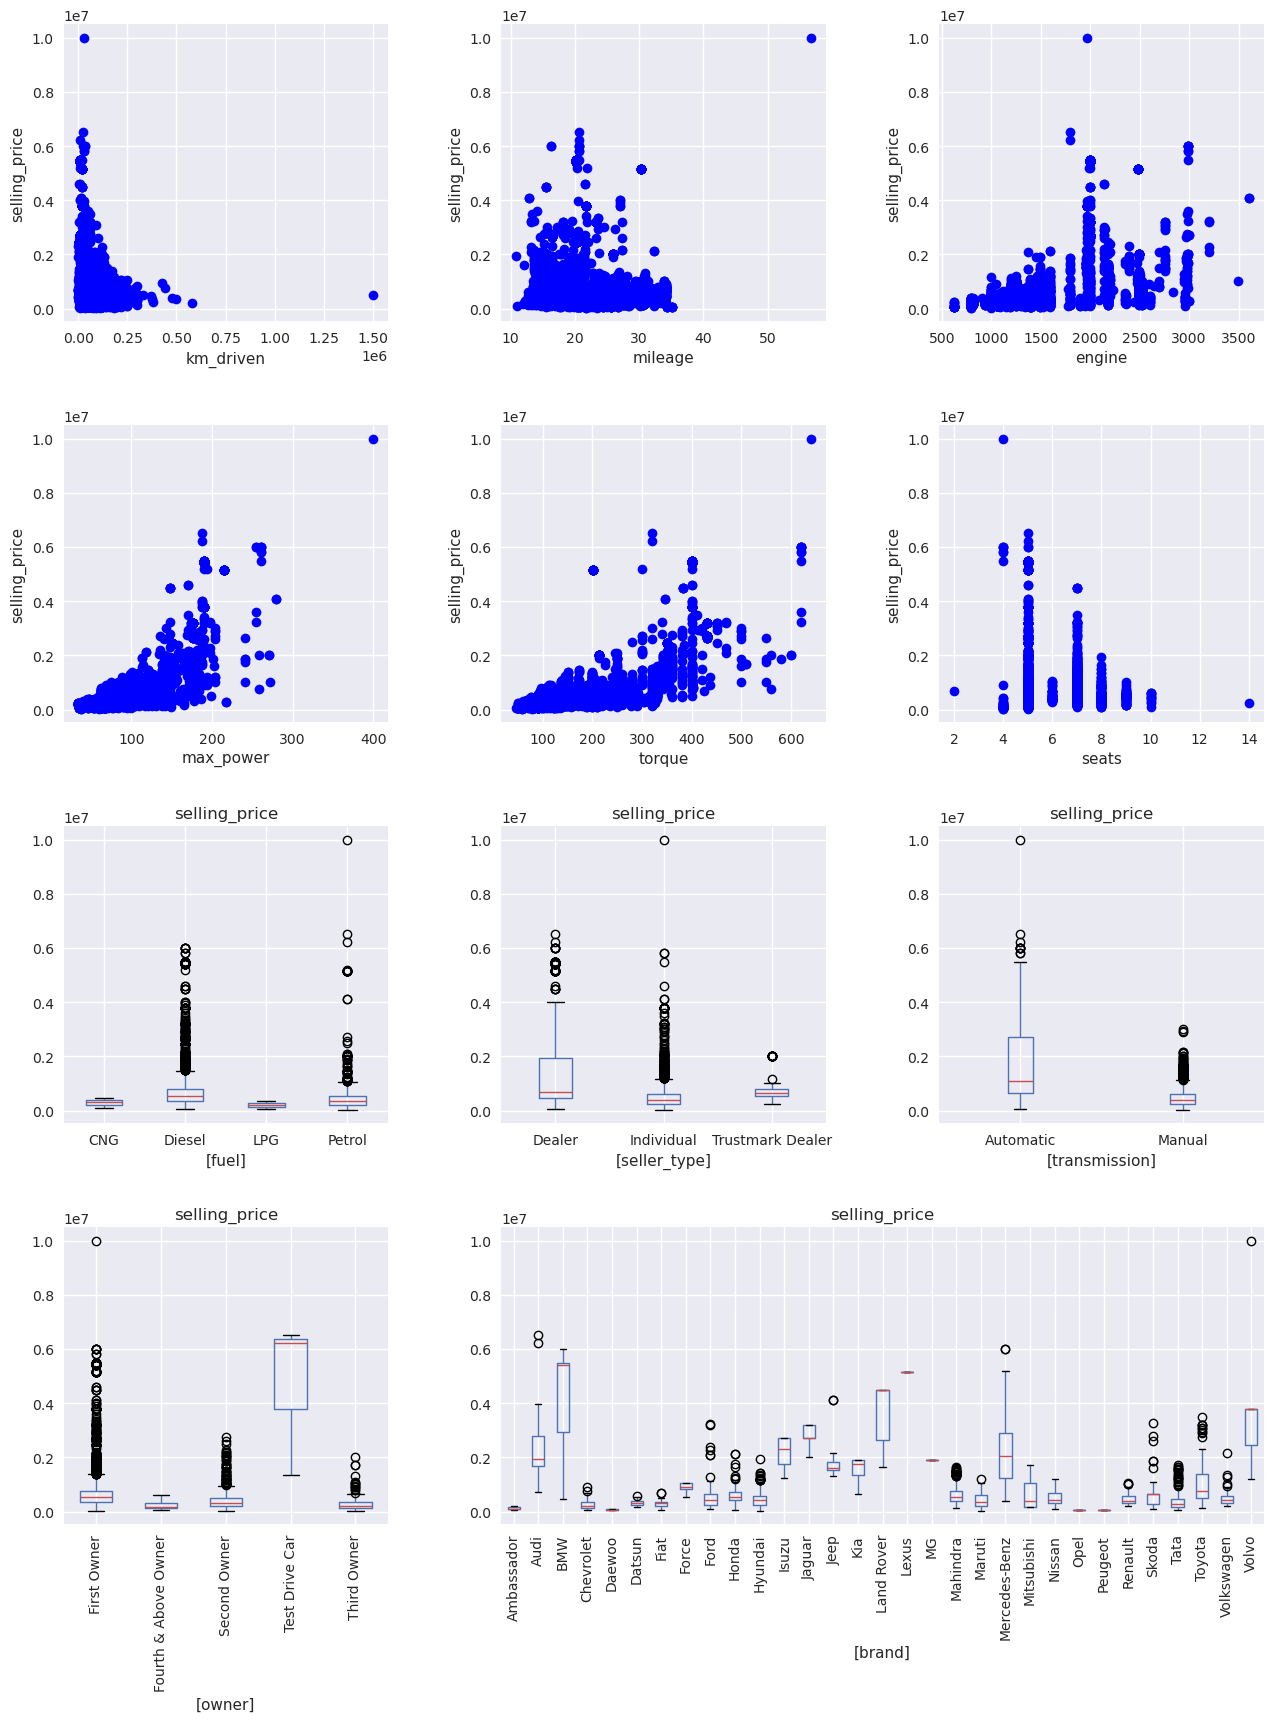

In [36]:
fig = plt.figure(figsize=(15, 20))
gs = mpl.gridspec.GridSpec(4, 3, wspace=0.35, hspace=0.35)

ax = fig.add_subplot(gs[0, 0])
ax.plot(X_train.km_driven, y_train, "bo")
ax.set_xlabel("km_driven"); ax.set_ylabel("selling_price")

ax = fig.add_subplot(gs[0, 1])
ax.plot(X_train.mileage, y_train, "bo")
ax.set_xlabel("mileage"); ax.set_ylabel("selling_price")

ax = fig.add_subplot(gs[0, 2])
ax.plot(X_train.engine, y_train, "bo")
ax.set_xlabel("engine"); ax.set_ylabel("selling_price")

ax = fig.add_subplot(gs[1, 0])
ax.plot(X_train.max_power, y_train, "bo")
ax.set_xlabel("max_power"); ax.set_ylabel("selling_price")

ax = fig.add_subplot(gs[1, 1])
ax.plot(X_train.torque, y_train, "bo")
ax.set_xlabel("torque"); ax.set_ylabel("selling_price")

ax = fig.add_subplot(gs[1, 2])
ax.plot(X_train.seats, y_train, "bo")
ax.set_xlabel("seats"); ax.set_ylabel("selling_price")

ax = fig.add_subplot(gs[2, 0])
df = pd.concat([y_train, X_train.fuel], axis=1)
df.boxplot(by="fuel", ax=ax)

ax = fig.add_subplot(gs[2, 1])
df = pd.concat([y_train, X_train.seller_type], axis=1)
df.boxplot(by="seller_type", ax=ax)

ax = fig.add_subplot(gs[2, 2])
df = pd.concat([y_train, X_train.transmission], axis=1)
df.boxplot(by="transmission", ax=ax)

ax = fig.add_subplot(gs[3, 0])
df = pd.concat([y_train, X_train.owner], axis=1)
df.boxplot(by="owner", ax=ax, rot=90)

ax = fig.add_subplot(gs[3, 1:3])
df = pd.concat([y_train, X_train.brand], axis=1)
df.boxplot(by="brand", ax=ax, rot=90)


fig.suptitle('')
plt.show(); plt.close()

In [38]:
print("Remove outliers:")
id = y_train > 0.8 * (10**7)
X_train = X_train[~id].reset_index(drop=True)
y_train = y_train[~id].reset_index(drop=True)

Remove outliers:


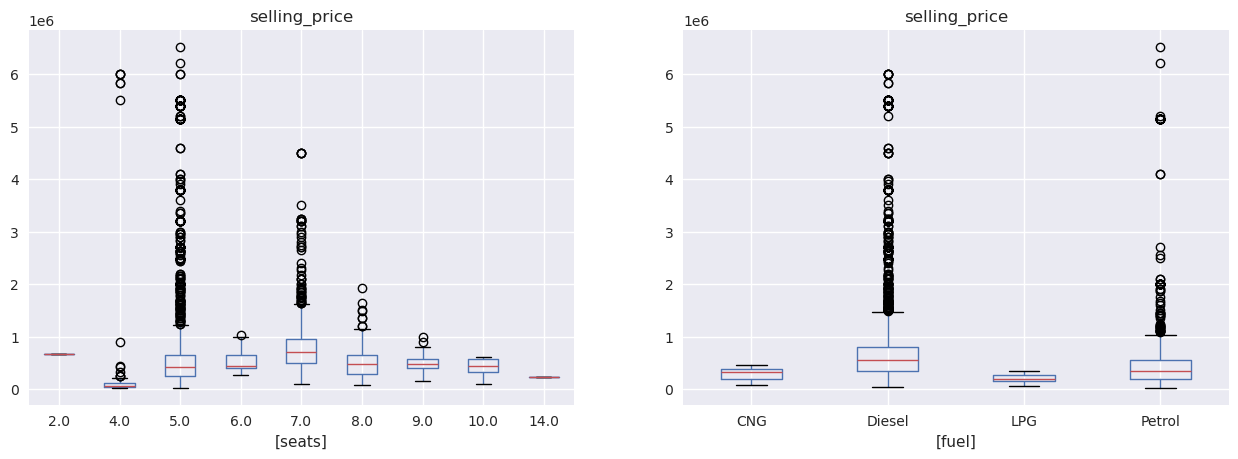

In [45]:
fig = plt.figure(figsize=(15, 5))
gs = mpl.gridspec.GridSpec(1, 2, hspace=0.2)

ax = fig.add_subplot(gs[0, 0])
df = pd.concat([y_train, X_train.seats], axis=1)
df.boxplot(by="seats", ax=ax)

ax = fig.add_subplot(gs[0, 1])
df = pd.concat([y_train, X_train.fuel], axis=1)
df.boxplot(by="fuel", ax=ax)


fig.suptitle('')
plt.show(); plt.close()

## <span style="color:darkblue; font-weight:bold"> C. Encoding some variables </span>

In [46]:
print("***Exclude some variables in train and test:")
Col_list_to_drop = ["fuel", "seller_type", "seats"]
X_train = X_train.drop(Col_list_to_drop, axis=1)
X_test = X_test.drop(Col_list_to_drop, axis=1)


print("\n***Encode owner:")
def Encode_owner(x):
    """
    Note: x is a string
    """
    if x == "First Owner": return 1
    if x == "Second Owner": return 2
    if x == "Third Owner": return 3
    if x == "Fourth & Above Owner": return 4
    if x == "Test Drive Car": return 5
    
X_train["owner"] = [Encode_owner(val) for val in X_train.owner]
X_test["owner"] = [Encode_owner(val) for val in X_test.owner]


print("\n***Standardizing engine and km_driven")
def Scale(s):
    return (s - s.mean()) / s.std()

X_train.engine = Scale(X_train.engine)
#train.mileage = Scale(train.mileage)
#train.max_power = Scale(train.max_power)
#train.torque= Scale(train.torque)
X_train.km_driven = Scale(X_train.km_driven)

X_test.engine = Scale(X_test.engine)
#test.mileage = Scale(test.mileage)
#test.max_power = Scale(test.max_power)
#test.torque= Scale(test.torque)
X_test.km_driven = Scale(X_test.km_driven)


print("\n***One-hot encode transmission, brand:")
X_train = pd.get_dummies(X_train, columns=["transmission", "brand"])
X_test = pd.get_dummies(X_test, columns=["transmission", "brand"])


print("\n***Add missing brands for both train and set")
Filter = [(x not in X_test.columns) for x in X_train.columns]
Cols_to_add = X_train.columns[Filter]
print("Brands in train but not in test:", Cols_to_add)

for i in Cols_to_add:
    X_test[i] = [False] * len(X_test)

Filter = [(x not in X_train.columns) for x in X_test.columns]
Cols_to_add = X_test.columns[Filter]
print("Brands in test but not in train:", Cols_to_add)

for i in Cols_to_add:
    X_train[i] = [False] * len(X_train)
        
        
print("\n***Align column order in train and test:")
X_train = X_train[sorted(X_train.columns)]
X_test = X_test[sorted(X_test.columns)]

***Exclude some variables in train and test:

***Encode owner:

***Standardizing engine and km_driven

***One-hot encode transmission, brand:

***Add missing brands for both train and set
Brands in train but not in test: Index(['brand_Ambassador', 'brand_Daewoo', 'brand_Force', 'brand_Kia',
       'brand_Land Rover', 'brand_MG', 'brand_Opel', 'brand_Peugeot'],
      dtype='object')
Brands in test but not in train: Index(['brand_Ashok'], dtype='object')

***Align column order in train and test:


In [47]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4799 entries, 0 to 4798
Data columns (total 41 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   brand_Ambassador        4799 non-null   bool   
 1   brand_Ashok             4799 non-null   bool   
 2   brand_Audi              4799 non-null   bool   
 3   brand_BMW               4799 non-null   bool   
 4   brand_Chevrolet         4799 non-null   bool   
 5   brand_Daewoo            4799 non-null   bool   
 6   brand_Datsun            4799 non-null   bool   
 7   brand_Fiat              4799 non-null   bool   
 8   brand_Force             4799 non-null   bool   
 9   brand_Ford              4799 non-null   bool   
 10  brand_Honda             4799 non-null   bool   
 11  brand_Hyundai           4799 non-null   bool   
 12  brand_Isuzu             4799 non-null   bool   
 13  brand_Jaguar            4799 non-null   bool   
 14  brand_Jeep              4799 non-null   

In [48]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 41 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   brand_Ambassador        1200 non-null   bool   
 1   brand_Ashok             1200 non-null   bool   
 2   brand_Audi              1200 non-null   bool   
 3   brand_BMW               1200 non-null   bool   
 4   brand_Chevrolet         1200 non-null   bool   
 5   brand_Daewoo            1200 non-null   bool   
 6   brand_Datsun            1200 non-null   bool   
 7   brand_Fiat              1200 non-null   bool   
 8   brand_Force             1200 non-null   bool   
 9   brand_Ford              1200 non-null   bool   
 10  brand_Honda             1200 non-null   bool   
 11  brand_Hyundai           1200 non-null   bool   
 12  brand_Isuzu             1200 non-null   bool   
 13  brand_Jaguar            1200 non-null   bool   
 14  brand_Jeep              1200 non-null   

## <span style="color:darkblue; font-weight:bold"> D. Model tuning </span>

In [57]:
print("***Parameter Tuning:")
#param_space = {
#    'n_estimators': (300, 350),               # Number of trees
#    'max_depth': [7],                    # Maximum tree depth
#    'learning_rate': [0.065], #(0.05, 0.1, 'log-uniform'),
#    'colsample_bytree':[0.833], #(0.6, 1, 'uniform'),
#    "subsample":[0.7289], #(0.7, 1, "uniform"),
#    "reg_alpha":[0.0054], #(0, 0.01, "uniform"),
#    "reg_lambda":[1.486], #(1, 2, "uniform"),
#    "gamma":[0],
#    "min_child_weight":[1/np.sqrt(37)]
#}

from skopt.space import Real, Integer
param_space = {
    'n_estimators': Integer(100, 1000),               # Number of trees
    'max_depth': [7],                                # Fixed value
    'learning_rate': Real(0.01, 0.1, prior='log-uniform'),
    'colsample_bytree': Real(0.6, 1.0, prior='uniform'),
    'subsample': Real(0.7, 1.0, prior='uniform'),
    'reg_alpha': Real(1e-3, 10, prior='uniform'),
    'reg_lambda': Real(1, 100, prior='uniform'),
    'gamma': Real(1e-3, 10.0, prior='log-uniform'),
    'min_child_weight': [1 / np.sqrt(37)]            # Fixed value
}


cv = KFold(n_splits=10, shuffle=True, random_state=113)

bayes_search = BayesSearchCV(
    estimator=XGBRegressor(random_state=113),
    search_spaces=param_space,
    n_iter=100,  #Number of parameter settings to sample
    cv=cv,
    n_jobs=-1,
    random_state=113,
    scoring='neg_mean_squared_error',
    refit=True) #Refit the best parameters on train set

bayes_search.fit(X_train, y_train);

***Parameter Tuning:


In [58]:
print("Best combo:\n", bayes_search.best_params_)

print("\nBest combo result:")
print("Mean Negative MSE:", bayes_search.cv_results_['mean_test_score'][bayes_search.best_index_])
print("STD Negative MSE:", bayes_search.cv_results_['std_test_score'][bayes_search.best_index_])

Best combo:
 OrderedDict({'colsample_bytree': 0.6332279725137684, 'gamma': 0.0018156901589710711, 'learning_rate': 0.050288890736263234, 'max_depth': 7, 'min_child_weight': 0.1643989873053573, 'n_estimators': 513, 'reg_alpha': 10.0, 'reg_lambda': 1.0, 'subsample': 0.9140046960293071})

Best combo result:
Mean Negative MSE: -12696903692.350111
STD Negative MSE: 3339861286.971896


***Result:
RMSE = 134499.6820313061
CV of Error
134416.33419980732
4734.296865234375


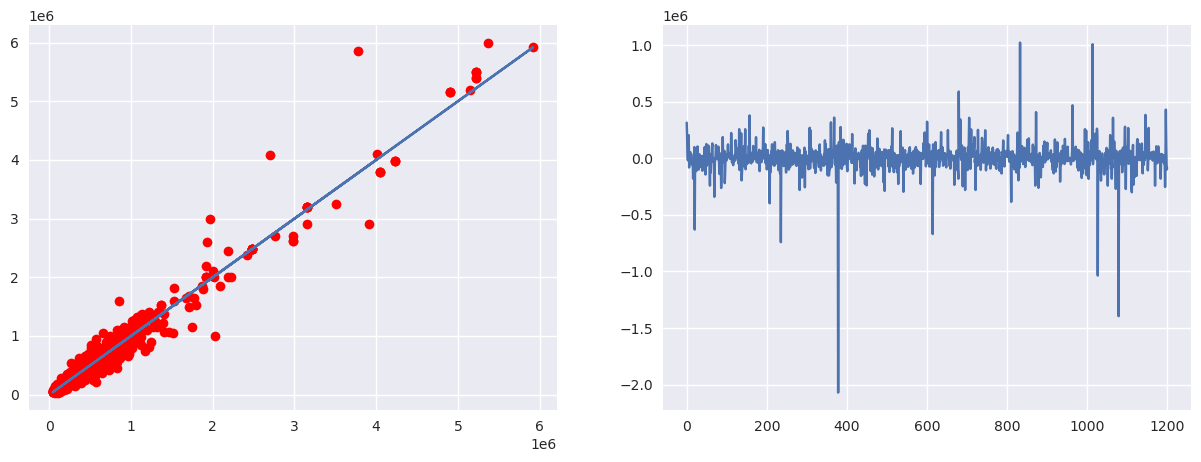

In [59]:
print("***Result:")
y_pred = bayes_search.predict(X_test)
RMSE = np.mean((y_pred - y_test)**2)**0.5
print("RMSE =", RMSE)
print("CV of Error")
print(np.std(y_pred - y_test))
print(np.mean(y_pred - y_test))

fig, (ax, ax1) = plt.subplots(1,2, figsize=(15,5))
ax.plot(y_pred, y_test, "ro")
ax.plot(y_pred, y_pred)

ax1.plot(range(len(y_pred)), y_pred-y_test)
plt.show(); plt.close()

In [27]:
id = (y_pred-y_test) < -10**6
print(X_test[id])
print(y_test[id], "\n\n")
print(y_pred[id])

      brand_Ambassador  brand_Ashok  brand_Audi  brand_BMW  brand_Chevrolet  \
378              False        False       False      False            False   
1078             False        False       False      False            False   

      brand_Daewoo  brand_Datsun  brand_Fiat  brand_Force  brand_Ford  ...  \
378          False         False       False        False       False  ...   
1078         False         False       False        False       False  ...   

      brand_Volvo    engine  km_driven  max_power    mileage  owner  torque  \
378         False  3.045392  -0.500125      282.0  16.265060      1   490.0   
1078        False  3.045392  -0.044160      224.0  14.457831      1   510.0   

      transmission_Automatic  transmission_Manual  year  
378                     True                False  2017  
1078                    True                False  2016  

[2 rows x 41 columns]
378     5850000
1078    4090000
Name: selling_price, dtype: int64 


[3611288.  2824244.8]
